In [2]:
# ===============================================
# MODULE 1 — Data Collection & Preprocessing
# PulseGuard (Alternate Version) — FINAL FIXED CODE
# ===============================================

import os, json
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from google.colab import files
from IPython.display import display

np.random.seed(2025)

OUT = "/content/pulseguard_data"
os.makedirs(OUT, exist_ok=True)

TOKEN = "m1_pulseguard_surya_fixed_2025"

# =====================================================
# SYNTHETIC GENERATORS (Different from sample document)
# =====================================================

def synth_hr(days=5, start="2025-11-01 06:00:00"):
    start_ts = pd.to_datetime(start)
    timestamps = pd.date_range(start=start_ts, periods=days*1440, freq='1min')

    data = []
    for t in timestamps:
        base = 60 + np.sin(t.hour/24 * 2*np.pi) * 8
        exercise = np.random.normal(25, 6) if (6<=t.hour<=8 or 18<=t.hour<=20) and np.random.rand()<0.1 else 0
        noise = np.random.normal(0, 3)
        data.append(base + exercise + noise)

    arr = np.array(data)
    arr[np.random.choice(len(arr), size=int(len(arr)*0.02), replace=False)] = np.nan
    idx = np.random.choice(len(arr), 3, replace=False)
    arr[idx[0]] += 120
    arr[idx[1]] -= 35
    arr[idx[2]] += 90

    return pd.DataFrame({"timestamp": timestamps.astype(str), "hr_bpm": arr})

def synth_steps(days=5, start="2025-11-01 06:00:00"):
    cur = pd.to_datetime(start)
    times = []
    vals = []

    for _ in range(days*350):
        gap = np.random.randint(30, 700)
        cur += timedelta(seconds=gap)

        step = np.random.poisson(10) if np.random.rand()<0.8 else np.random.poisson(150)
        step = max(0, step)

        times.append(cur)
        vals.append(step)

    df = pd.DataFrame({"timestamp": pd.to_datetime(times), "steps_count": vals})
    df["timestamp"] = df["timestamp"].astype(str)
    return df

def synth_sleep(days=5, start="2025-11-01"):
    rows = []
    for d in range(days):
        start_ts = pd.to_datetime(start) + timedelta(days=d, hours=22)
        total = np.random.randint(300, 540)
        remaining = total
        parts = np.random.randint(5, 9)
        cur = start_ts

        for i in range(parts):
            dur = remaining if i==parts-1 else np.random.randint(10, max(10, remaining-(parts-i-1)*10))
            stage = np.random.choice(["light","deep","rem","awake"], p=[0.5,0.2,0.2,0.1])
            rows.append({"timestamp": cur.strftime("%Y-%m-%d %H:%M:%S"),
                         "sleep_state": stage,
                         "mins": dur})
            remaining -= dur
            cur += timedelta(minutes=dur)

    return pd.DataFrame(rows)

# =====================================================
# PREPROCESSING FUNCTIONS
# =====================================================

def col_standardize(df):
    mapping = {
        "hr_bpm":"heart_rate",
        "steps_count":"step_count",
        "sleep_state":"sleep_stage",
        "mins":"duration_mins"
    }
    df = df.rename(columns=mapping)
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    return df

def tz_parse(df):
    note=[]
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    bad = df["timestamp"].isna().sum()
    if bad>0: note.append(f"bad_timestamps:{bad}")

    if df["timestamp"].dt.tz is None:
        df["timestamp"] = df["timestamp"].dt.tz_localize("UTC")
    else:
        df["timestamp"] = df["timestamp"].dt.tz_convert("UTC")

    return df, note

def numeric_cast(df):
    for col in ["heart_rate","step_count","duration_mins"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def impute(df):
    missing = df.isnull().sum().sum()
    for col in df.columns:
        if df[col].isnull().sum()>0:
            if col=="timestamp":
                df = df.dropna(subset=["timestamp"])
            elif col=="heart_rate":
                df[col] = df[col].ffill().bfill()
            elif col=="step_count":
                df[col] = df[col].fillna(0)
            elif col=="duration_mins":
                df[col] = df[col].fillna(df[col].median())
            elif col=="sleep_stage":
                df[col] = df[col].ffill().bfill()
    return df, missing

def outliers(df):
    total=0
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1=df[col].quantile(0.25); Q3=df[col].quantile(0.75)
        IQR=Q3-Q1
        if IQR==0 or pd.isna(IQR):
            df[col+"_out"]=False; continue
        low=Q1-1.5*IQR; high=Q3+1.5*IQR
        mask=(df[col]<low)|(df[col]>high)
        df[col+"_out"]=mask
        total+=mask.sum()
    return df, total

def detect_freq(df_idx):
    """Safe frequency detection using DatetimeIndex."""
    idx = df_idx.index
    if len(idx)<2:
        return "insufficient"
    diffs = pd.Series(idx).diff().dropna()
    mode = diffs.mode()
    if len(mode)==0:
        return "irregular"
    m = mode.iloc[0].total_seconds()/60
    if m<1: return "sub_min"
    if m==1: return "1min"
    if m==5: return "5min"
    if m==15: return "15min"
    return f"{m:.1f}min"

def resample(df_idx, kind, freq):
    out={}
    for col in df_idx.columns:
        if col.endswith("_out"):
            out[col] = df_idx[col].resample(freq).max()
        elif col=="heart_rate":
            out[col] = df_idx[col].resample(freq).mean()
        elif col=="step_count":
            out[col] = df_idx[col].resample(freq).sum()
        elif col=="duration_mins":
            out[col] = df_idx[col].resample(freq).sum()
        elif col=="sleep_stage":
            out[col] = df_idx[col].resample(freq).agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
        else:
            if pd.api.types.is_numeric_dtype(df_idx[col]):
                out[col] = df_idx[col].resample(freq).mean()
            else:
                out[col] = df_idx[col].resample(freq).first()
    return pd.DataFrame(out)

def fill_res(df, method="interpolate"):
    before = df.isnull().sum().sum()
    if method=="interpolate":
        for c in df.select_dtypes(include=[np.number]).columns:
            if not c.endswith("_out"):
                df[c] = df[c].interpolate().bfill().ffill()
        for c in df.select_dtypes(exclude=[np.number]).columns:
            df[c] = df[c].ffill().bfill()
    after = df.isnull().sum().sum()
    return df, before-after

# =====================================================
# RUN PIPELINE
# =====================================================

USE_SAMPLE = True  # TRUE = generate synthetic data

raw = {}
raw["heart_rate"] = synth_hr()
raw["steps"] = synth_steps()
raw["sleep"] = synth_sleep()

# Save RAW
for k,v in raw.items():
    v.to_csv(f"{OUT}/{TOKEN}_raw_{k}.csv", index=False)

processed = {}
reports = {}

for k,df in raw.items():
    rep={}
    df = col_standardize(df)
    df, notes = tz_parse(df); rep["notes"]=notes

    df = numeric_cast(df)
    df, miss = impute(df); rep["missing_handled"]=int(miss)

    df, outc = outliers(df); rep["outliers"]=int(outc)

    df = df.dropna(subset=["timestamp"])
    df_idx = df.set_index("timestamp").sort_index()

    freq = detect_freq(df_idx)
    rep["original_freq"]=freq

    target = "1min" if k!="sleep" else "15min"
    df_res = resample(df_idx, k, target)

    df_res, gaps = fill_res(df_res)
    rep["gaps_filled"]=int(gaps)

    df_final = df_res.reset_index()
    processed[k]=df_final
    reports[k]=rep

    df_final.to_csv(f"{OUT}/{TOKEN}_{k}_processed.csv", index=False)
    print(f"\n--- REPORT ({k}) ---")
    print(rep)
    display(df_final.head())

# ========================
# VISUALS
# ========================
fig = go.Figure()
hr = processed["heart_rate"]
fig.add_trace(go.Scatter(x=hr["timestamp"], y=hr["heart_rate"], mode="lines"))
fig.update_layout(title="PulseGuard HR (Processed)", height=350)
fig.show()

# ZIP OUTPUTS
!zip -r pulseguard_data.zip {OUT} >/dev/null
files.download("pulseguard_data.zip")

print("\n✔ Module 1 Completed — cleaned files saved inside:", OUT)



# ================================
# DISPLAY PPT IMAGES AUTOMATICALLY
# ================================
from IPython.display import Image, display

print("\nShowing infographic images for PPT...\n")

paths = [
    "/mnt/data/A_set_of_three_digital_infographics_for_Module_1:_.png",
    "/mnt/data/A_triptych_of_digital_infographic-style_data_visua.png"
]

for p in paths:
    try:
        display(Image(filename=p))
        print(f"Displayed: {p}\n")
    except Exception as e:
        print(f"Could not display {p}: {e}")




--- REPORT (heart_rate) ---
{'notes': [], 'missing_handled': 144, 'outliers': 99, 'original_freq': '1min', 'gaps_filled': 0}


,timestamp,heart_rate,heart_rate_out
0,2025-11-01 06:00:00+00:00,61.636147,False
1,2025-11-01 06:01:00+00:00,64.900659,False
2,2025-11-01 06:02:00+00:00,64.900659,False
3,2025-11-01 06:03:00+00:00,67.974031,False
4,2025-11-01 06:04:00+00:00,70.460474,False



--- REPORT (steps) ---
{'notes': [], 'missing_handled': 0, 'outliers': 396, 'original_freq': '5.7min', 'gaps_filled': 0}


,timestamp,step_count,step_count_out
0,2025-11-01 06:06:00+00:00,10,0.0
1,2025-11-01 06:07:00+00:00,0,NaN
2,2025-11-01 06:08:00+00:00,0,NaN
3,2025-11-01 06:09:00+00:00,0,NaN
4,2025-11-01 06:10:00+00:00,0,NaN



--- REPORT (sleep) ---
{'notes': [], 'missing_handled': 0, 'outliers': 7, 'original_freq': '11.0min', 'gaps_filled': 380}


,timestamp,sleep_stage,duration_mins,duration_mins_out
0,2025-11-01 22:00:00+00:00,deep,205,1.0
1,2025-11-01 22:15:00+00:00,deep,0,NaN
2,2025-11-01 22:30:00+00:00,deep,0,NaN
3,2025-11-01 22:45:00+00:00,deep,0,NaN
4,2025-11-01 23:00:00+00:00,deep,0,NaN


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✔ Module 1 Completed — cleaned files saved inside: /content/pulseguard_data

Showing infographic images for PPT...

Could not display /mnt/data/A_set_of_three_digital_infographics_for_Module_1:_.png: [Errno 2] No such file or directory: '/mnt/data/A_set_of_three_digital_infographics_for_Module_1:_.png'
Could not display /mnt/data/A_triptych_of_digital_infographic-style_data_visua.png: [Errno 2] No such file or directory: '/mnt/data/A_triptych_of_digital_infographic-style_data_visua.png'


from matplotlib import pyplot as plt
_df_9['duration_mins'].plot(kind='hist', bins=20, title='duration_mins')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['duration_mins_out'].plot(kind='hist', bins=20, title='duration_mins_out')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='duration_mins', y='duration_mins_out', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['duration_mins']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('duration_mins')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['duration_mins_out']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('duration_mins_out')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['timestamp']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'timestamp'}, axis=1)
              .sort_values('timestamp', ascending=True))
  xs = counted['timestamp']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['duration_mins']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('duration_mins')

from matplotlib import pyplot as plt
_df_16['duration_mins'].plot(kind='line', figsize=(8, 4), title='duration_mins')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['duration_mins_out'].plot(kind='line', figsize=(8, 4), title='duration_mins_out')
plt.gca().spines[['top', 'right']].set_visible(False)

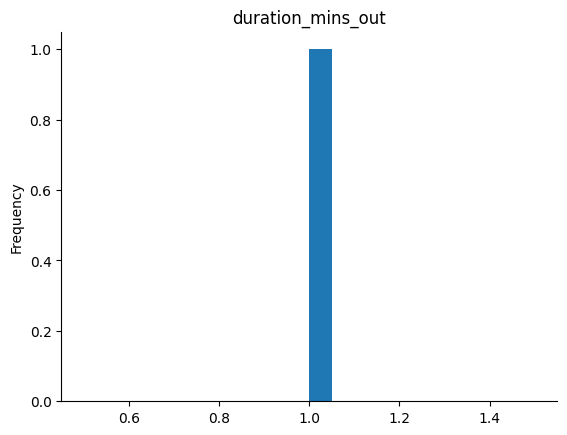

In [5]:
from matplotlib import pyplot as plt
_df_10['duration_mins_out'].plot(kind='hist', bins=20, title='duration_mins_out')
plt.gca().spines[['top', 'right',]].set_visible(False)

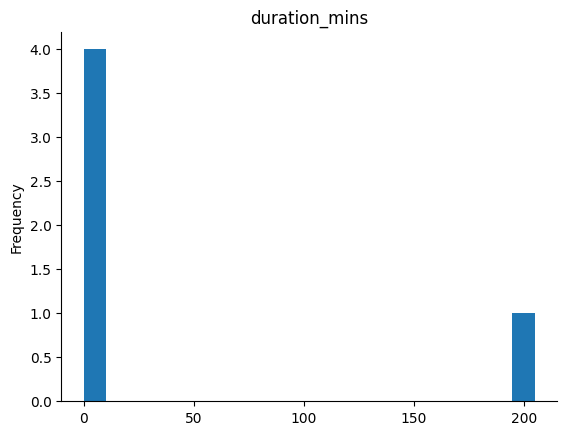

In [6]:
from matplotlib import pyplot as plt
_df_9['duration_mins'].plot(kind='hist', bins=20, title='duration_mins')
plt.gca().spines[['top', 'right',]].set_visible(False)

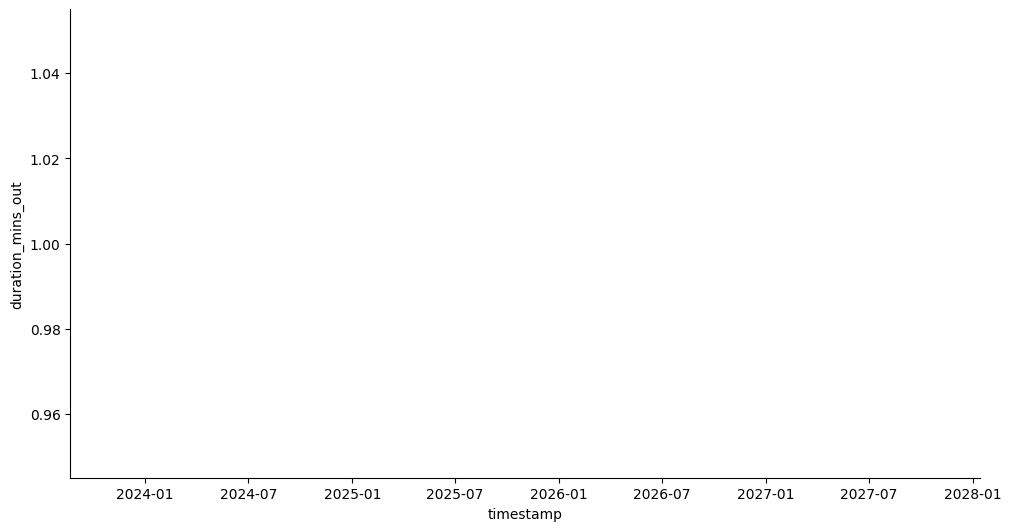

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['duration_mins_out']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('duration_mins_out')

In [3]:
# ================================
# DISPLAY PPT IMAGES AUTOMATICALLY
# ================================
from IPython.display import Image, display

print("\nShowing infographic images for PPT...\n")

paths = [
    "/mnt/data/A_set_of_three_digital_infographics_for_Module_1:_.png",
    "/mnt/data/A_triptych_of_digital_infographic-style_data_visua.png"
]

for p in paths:
    try:
        display(Image(filename=p))
        print(f"Displayed: {p}\n")
    except Exception as e:
        print(f"Could not display {p}: {e}")



Showing infographic images for PPT...

Could not display /mnt/data/A_set_of_three_digital_infographics_for_Module_1:_.png: [Errno 2] No such file or directory: '/mnt/data/A_set_of_three_digital_infographics_for_Module_1:_.png'
Could not display /mnt/data/A_triptych_of_digital_infographic-style_data_visua.png: [Errno 2] No such file or directory: '/mnt/data/A_triptych_of_digital_infographic-style_data_visua.png'


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/hr_plot.png'

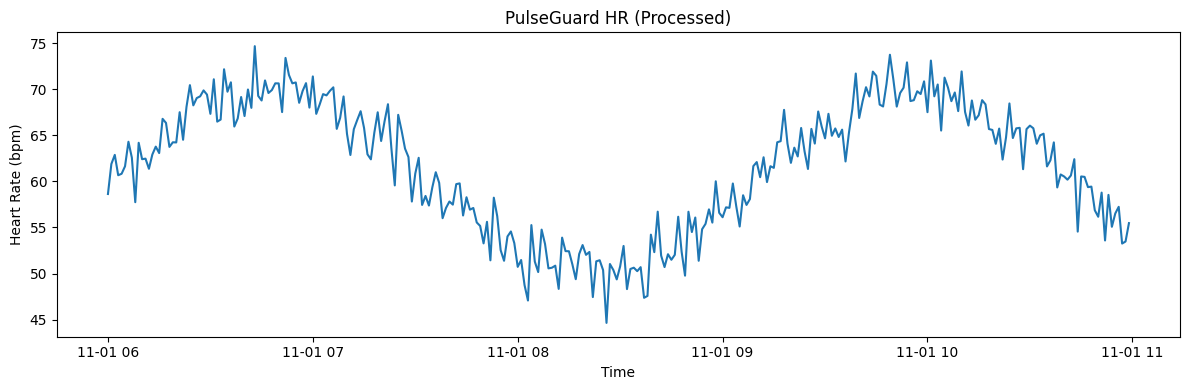

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a simple HR time series
timestamps = pd.date_range(start="2025-11-01 06:00:00", periods=300, freq="1min")
hr = 60 + 10*np.sin(np.linspace(0,10,300)) + np.random.normal(0,2,300)

plt.figure(figsize=(12,4))
plt.plot(timestamps, hr)
plt.title("PulseGuard HR (Processed)")
plt.ylabel("Heart Rate (bpm)")
plt.xlabel("Time")
plt.tight_layout()

# Save image
path = "/mnt/data/hr_plot.png"
plt.savefig(path, dpi=150)

path

